
# 1 - Уменьшение палитры изображения
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

In [ ]:
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import pylab
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize
from PIL import Image
from sklearn.model_selection import GridSearchCV
import pandas as pd

In [ ]:
def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image)
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

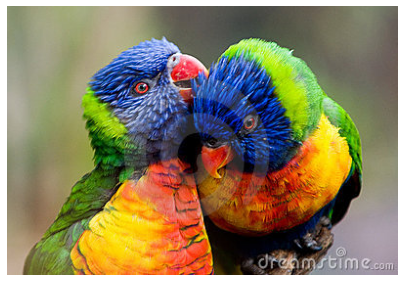

In [ ]:
img = cv2.imread('birds.jpg')
draw_picture(img)

In [ ]:
img.shape

(275, 400, 3)

In [ ]:
def draw_more_pictures(img, img_cluster, model=None, bgr=False):
    images = []
    for cluster in img_cluster:
        b, g, r = cv2.split(cluster)
        new_image = cv2.merge([r, g, b])
        images.append(new_image)
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
    if model != None:
        ax1.imshow(images[0])
        ax1.axis('off')
        ax1.set_title(f'SSIM = {round(ssim(img, images[0], multichannel=True), 2)} ')
        ax2.imshow(images[1])
        ax2.axis('off')
        ax2.set_title(f'SSIM = {round(ssim(img, images[1], multichannel=True), 2)}')
        ax3.imshow(images[2])
        ax3.axis('off')
        ax3.set_title(f'SSIM = {round(ssim(img, images[2], multichannel=True), 2)}')
        ax4.imshow(images[3])
        ax4.axis('off')
        ax4.set_title(f'SSIM = {round(ssim(img, images[3], multichannel=True), 2)}')

    else:
        ax1.imshow(images[0])
        ax1.axis('off')
        ax1.set_title(f'K = 2, SSIM = {round(ssim(img, images[0], multichannel=True), 2)} ')
        ax2.imshow(images[1])
        ax2.axis('off')
        ax2.set_title(f'K = 3, SSIM = {round(ssim(img, images[1], multichannel=True), 2)}')
        ax3.imshow(images[2])
        ax3.axis('off')
        ax3.set_title(f'K = 10, SSIM = {round(ssim(img, images[2], multichannel=True), 2)}')
        ax4.imshow(images[3])
        ax4.axis('off')
        ax4.set_title(f'K = 20, SSIM = {round(ssim(img, images[3], multichannel=True), 2)}')

### K-means

In [ ]:
def k_means(img, draw_more_pictures):
    clusters = [2, 3, 10, 20]
    img = img / 255
    img_cluster = []
    for k in clusters:    
        X = img.reshape(-1, 3)
        km = KMeans(n_clusters=k)
        km.fit(X)
        img_seg = km.cluster_centers_
        img_seg = img_seg[km.labels_]
        img_seg = img_seg.reshape(img.shape)
        img_cluster.append(img_seg)
    return draw_more_pictures(img, img_cluster)

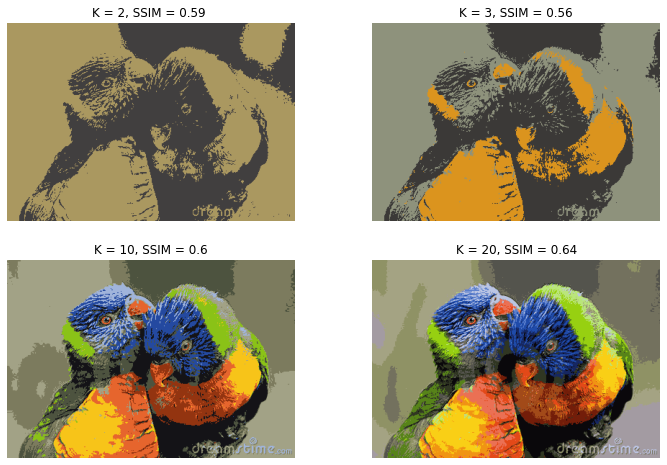

In [ ]:
k_means(img, draw_more_pictures)

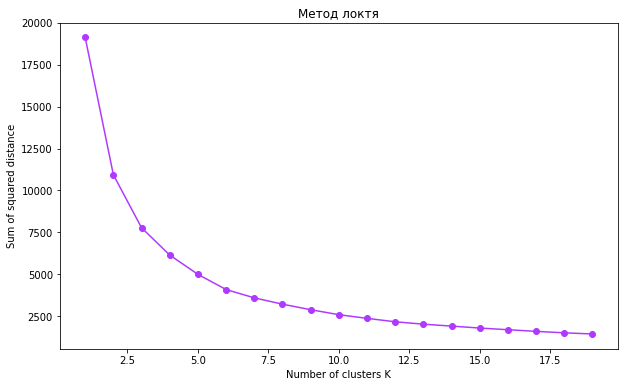

In [ ]:
X_scale = (img / 255).reshape(-1, 3)
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_scale)
    sse.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(list_k, sse, '-o', color='#AF39FE')
plt.title('Метод локтя')
plt.xlabel(r'Number of clusters K')
plt.ylabel('Sum of squared distance');

Как видно, на этой картинке нет того самого выраженного "локтя", как обычно бывает, функция при увеличении кластеров убывает почти монотонно, без изгибов

### DBSCAN

In [ ]:
X = img.reshape(-1, 3)
X_list = []
for i in range(len(X)):
    X_list.append(list(X[i]))

In [ ]:
def dbscan_algorithm(replace):
    samples = [1, 2, 4, 6]
    image_dbsan = []
    for sample in samples:
        ds = DBSCAN(eps=3, min_samples=sample)
        ds.fit(X)

        labels = []
        list(pd.DataFrame(ds.labels_).value_counts().index)
        for i in range(len(list(pd.DataFrame(ds.labels_).value_counts().index))):
            labels.append(list(pd.DataFrame(ds.labels_).value_counts().index[i])[0])

        img_label = list(zip(X_list, ds.labels_))
        count_labels = list(zip(list(pd.DataFrame(ds.labels_).value_counts().values), labels))
        points_labels = []
        if replace == 'median':
            for label in labels:
                points = []
                for i in range(len(img_label)):
                    if img_label[i][1] == label:
                        points.append(img_label[i][0])
                points_sort = sorted(points)
                med = len(points_sort)//2
                points_labels.append(points_sort[med])
            point_img = list(zip(points_labels, labels))
        elif replace == 'mean':
            for i in range(len(count_labels)):
                sum1, sum2, sum3 = 0, 0, 0
                for j in range(len(img_label)):
                    if img_label[j][1] == count_labels[i][1]:
                        sum1 += img_label[j][0][0]
                        sum2 += img_label[j][0][1]
                        sum3 += img_label[j][0][2]
                points_labels.append([round(sum1/count_labels[i][0]), round(sum2/count_labels[i][0]), round(sum3/count_labels[i][0])])
            point_img = list(zip(points_labels, labels))
        X_clust = []
        for i in range(len(img_label)):
            for j in range(len(point_img)):
                if img_label[i][1] == point_img[j][1]:
                    X_clust.append(point_img[j][0])
        X_clust = np.array(X_clust)
        new_img = X_clust.reshape(img.shape)
        image_dbsan.append(new_img)
    return draw_more_pictures(img, image_dbsan, model=ds)

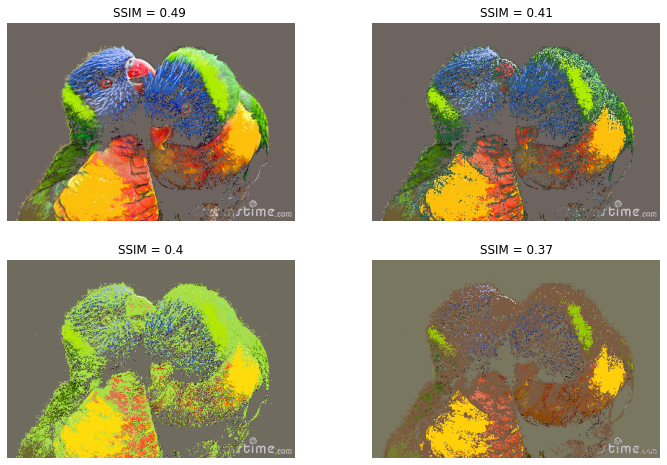

In [ ]:
dbscan_algorithm('median')

/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


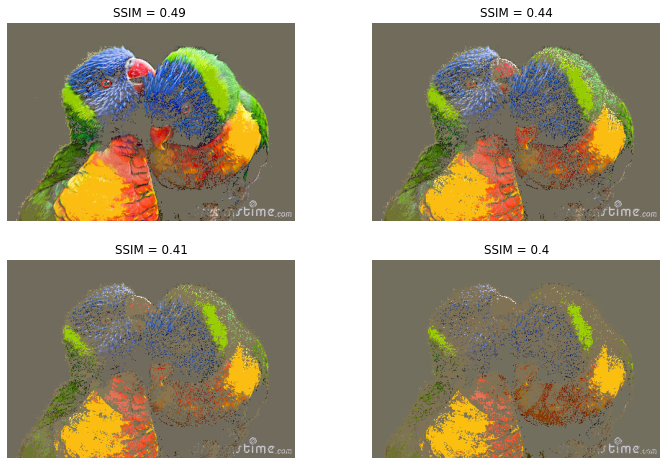

In [ ]:
dbscan_algorithm('mean')

### AgglomerativeClustering

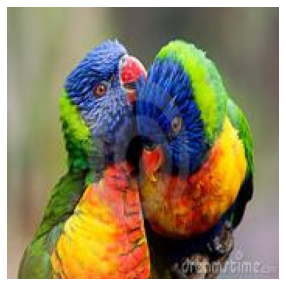

In [ ]:
im = Image.open("birds.jpg")
img1 = im.resize((175, 175))
img1.save('resize_birds.jpg')
img_resize = cv2.imread('resize_birds.jpg')
draw_picture(img_resize)

In [ ]:
def draw_agglomerative(img, img_cluster, bgr=False):
    images = []
    for cluster in img_cluster:
        b, g, r = cv2.split(cluster)
        new_image = cv2.merge([r, g, b])
        images.append(new_image)
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(nrows=2, ncols=2, figsize=(12,8))
    ax1.imshow(images[0])
    ax1.axis('off')
    ax1.set_title(f'K = 2, SSIM = {round(ssim(img/255, images[0], multichannel=True), 2)} ')
    ax2.imshow(images[1])
    ax2.axis('off')
    ax2.set_title(f'K = 3, SSIM = {round(ssim(img/255, images[1], multichannel=True), 2)}')
    ax3.imshow(images[2])
    ax3.axis('off')
    ax3.set_title(f'K = 10, SSIM = {round(ssim(img/255, images[2], multichannel=True), 2)}')
    ax4.imshow(images[3])
    ax4.axis('off')
    ax4.set_title(f'K = 20, SSIM = {round(ssim(img/255, images[3], multichannel=True), 2)}')

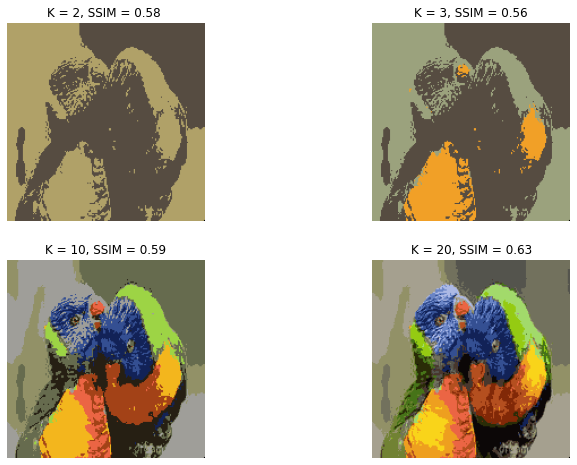

In [ ]:
image_cluster = []

X  = img_resize.reshape(-1, 3) / 255
cluster_number=[2, 3, 10, 20]
for i in range(1,len(cluster_number) + 1):
    agglom = AgglomerativeClustering(n_clusters=cluster_number[i-1]).fit(X)
    clusters= agglom.fit_predict(X)
    clusters = np.asmatrix(clusters)
    clusters = np.transpose(clusters)
    clustered_X = np.append(X,clusters,axis=1)

    ColNames=['R','G','B','cluster']
    DF = pd.DataFrame(clustered_X, columns=ColNames)
    Red = DF.groupby('cluster')['R'].mean()
    Green = DF.groupby('cluster')['G'].mean()
    Blue = DF.groupby('cluster')['B'].mean()
    RGB = pd.concat([Red,Green,Blue],axis=1)
    RGB = RGB.values
    transf_image = np.zeros((len(X),3))
      
    for j in range(0,len(X)-1):
        transf_image[j,:] = RGB[clusters[j]]
              
    new_image = transf_image.ravel().reshape(img_resize.shape[0], img_resize.shape[1], img_resize.shape[2])
    image_cluster.append(new_image)
draw_agglomerative(img_resize, image_cluster)

**Вывод**: для этой картинки больше всего подошла модель k-means, во-первых, очень четкое изображение (по сравнению с dbscan у которого много шума), во-вторых, не нужно ресайзить изображение (по сравнению с аггломеративной кластеризацией, хотя значение метрики ssim примерно одинаковое)

# 2 - Уменьшение размерности помогает классификации лиц

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности


Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс?

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ.

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим?

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE?

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [ ]:
from sklearn.model_selection import train_test_split
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [ ]:
X.shape # 2370 лиц, каждый из них представляется вектором размера 11750

(2370, 11750)

In [ ]:
y.shape

(2370,)

In [ ]:
names[8] # в y лежат номера, а names переводит номер в имя

'George W Bush'

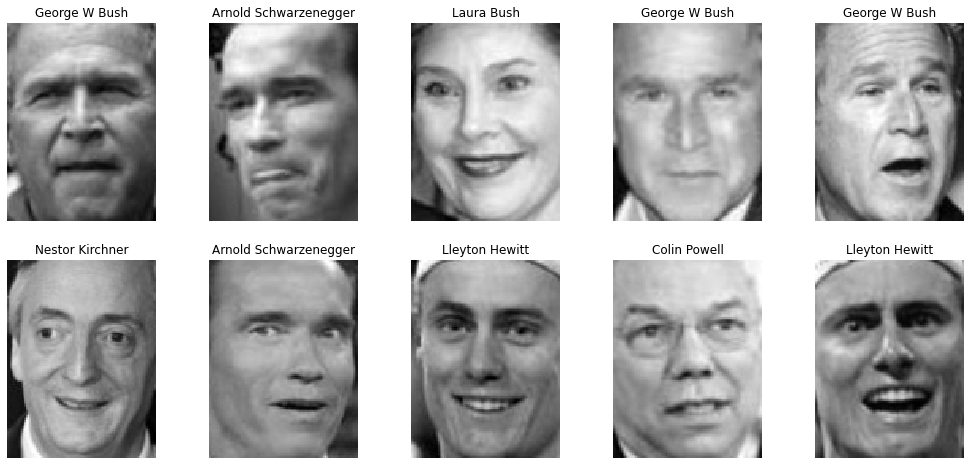

In [ ]:
import matplotlib.pyplot as plt
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

Обучение без понижения размерности

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'accuracy: {accuracy_score(y_test, y_pred)}')

accuracy: 0.6729957805907173


Обучение с понижением размерности с использование PCA

In [ ]:
pca  = PCA(n_components=1000)
X_pca_train = pca.fit(X_train).transform(X_train)
X_pca_test = pca.transform(X_test)

model1 = LogisticRegression()
model1.fit(X_pca_train, y_train)
y_pred = model1.predict(X_pca_test)
print(f'accuracy: {accuracy_score(y_test, y_pred)}')

accuracy: 0.7130801687763713


In [ ]:
clusters = list(pd.DataFrame(y)[0].unique())

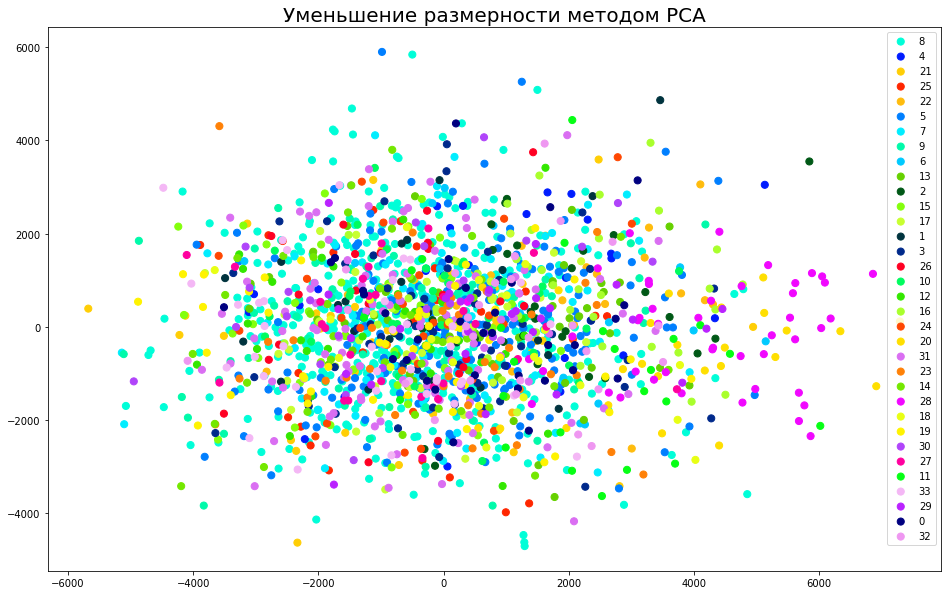

In [ ]:
plt.figure(figsize=(16, 10))
for cluster in clusters:
    norm = Normalize(vmin=0, vmax=35)
    color = plt.cm.gist_ncar(norm(cluster))
    plt.scatter(X_pca_train[:, 0][y_train == cluster],
                X_pca_train[:, 1][y_train == cluster],
                c=[color] * len(X_pca_train[:, 0][y_train == cluster]), label=cluster, edgecolor='face', s=50)
plt.title(u"Уменьшение размерности методом PCA", fontsize=20)
plt.legend();

Обучение с понижением размерности с использованием TSNE

In [ ]:
tsne  = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

In [ ]:
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(X_tsne, y, test_size=0.2, random_state=42)

In [ ]:
model2 = LogisticRegression()
model2.fit(X_train_tsne, y_train_tsne)
y_pred = model2.predict(X_test_tsne)
print(f'accuracy: {accuracy_score(y_test, y_pred)}')

accuracy: 0.24261603375527427


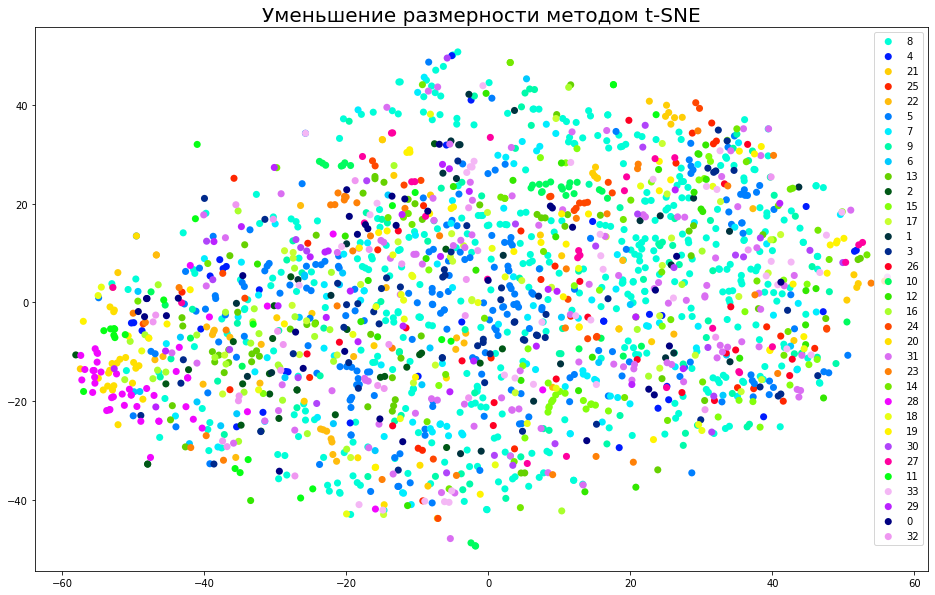

In [ ]:
plt.figure(figsize=(16, 10))
for cluster in clusters:
    norm = Normalize(vmin=0, vmax=35)
    color = plt.cm.gist_ncar(norm(cluster))
    plt.scatter(X_train_tsne[:, 0][y_train_tsne == cluster],
                X_train_tsne[:, 1][y_train_tsne == cluster],
                c=[color] * len(X_train_tsne[:, 0][y_train_tsne == cluster]), label=cluster, edgecolor='none', s=50)
plt.title(u"Уменьшение размерности методом t-SNE", fontsize=20)
plt.legend();

Константное предсказание (всегда самый популярный класс)

In [ ]:
pd.DataFrame(y).value_counts()[:5]

8     530
5     236
31    144
7     121
9     109
dtype: int64

Самый популярный класс - 8

In [ ]:
y_const_pred = 8*np.ones((474,))

In [ ]:
accuracy_score(y_test, y_const_pred)

0.23839662447257384

Итог: константное предсказание почти такое же как и T-SNE, однако в 3 раза хуже PCA

PCA себя показал лучше, он определяет бОльшее количество людей верно, поэтому буду использовать его

In [ ]:
y_pred = model1.predict(X_pca_test)
print(f'accuracy: {accuracy_score(y_test, y_pred)}')

accuracy: 0.7130801687763713


In [ ]:
print(y_pred[:5]) #предсказанные алгоритмом классы
print(y_test[:5]) #верные классы

[ 1 13 29 22  8]
[ 9 13  9 22  8]


Можно заметить, что на 1 и 3 фотке алгоритм ошибся (индексы 0 и 2), визуализируем эти ошибки

In [ ]:
def find_index(y_new, k):
    for i in range(len(y)):
        if y_new[k] == y[i]:
            p = i
            return p

In [ ]:
def pred_mistake(k):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
    ax1.imshow(255 - lfw_people['images'][find_index(y_test, k)], cmap=plt.cm.gray_r, interpolation='nearest')
    ax1.axis('off')
    ax1.set_title(names[y_test[k]])
    ax2.imshow(255 - lfw_people['images'][find_index(y_pred, k)], cmap=plt.cm.gray_r, interpolation='nearest')
    ax2.axis('off')
    ax2.set_title(names[y_pred[k]])

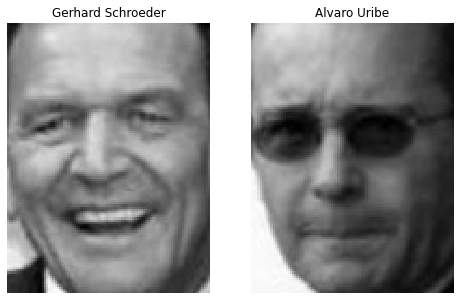

In [ ]:
pred_mistake(0)

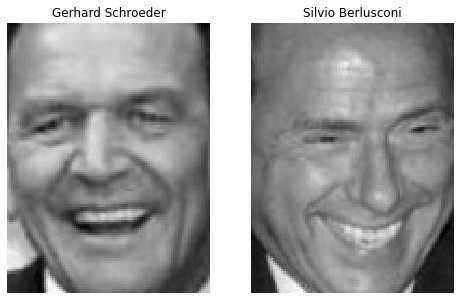

In [ ]:
pred_mistake(2)

Нарисуем на плоскости наш датасет и подпишем 3 самых популярных класса (фамилию и имя)

In [ ]:
pca = PCA(n_components=1000)
X_pca = pca.fit(X).transform(X)

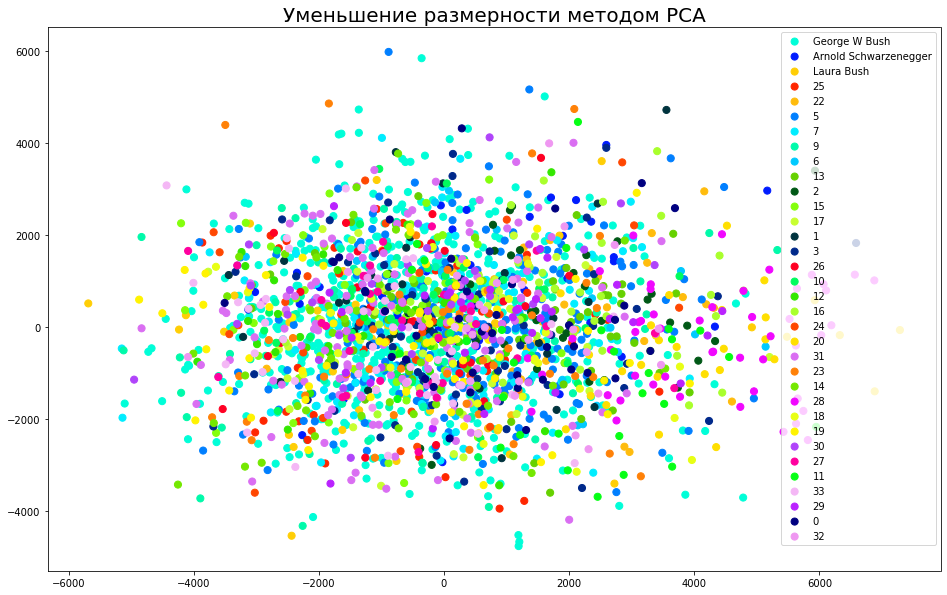

In [ ]:
plt.figure(figsize=(16, 10))
k = 0
for cluster in clusters:
    norm = Normalize(vmin=0, vmax=35)
    color = plt.cm.gist_ncar(norm(cluster))
    if k <= 2:
        plt.scatter(X_pca[:, 0][y == cluster],
                    X_pca[:, 1][y == cluster],
                    c=[color] * len(X_pca[:, 0][y == cluster]), label=names[cluster], edgecolor='face', s=50)
    else:
        plt.scatter(X_pca[:, 0][y == cluster],
                    X_pca[:, 1][y == cluster],
                    c=[color] * len(X_pca[:, 0][y == cluster]), label=cluster, edgecolor='face', s=50)
    k += 1
plt.title(u"Уменьшение размерности методом PCA", fontsize=20)
plt.legend();

**Вывод**: PCA на датасете с лицами показал себя лучше, если смотреть на визуализацию, то ощутимых различий в моделях нет, у PCA более густое облако, а у TSNE более разреженное, но если смотреть на accuracy, то очевидным лидером является PCA